In [1]:
start_date_str = 'Tue Oct 06 2020 00:00:00 GMT-0700 (Pacific Daylight Time)'
fuel_type = 'CCGT'

In [2]:
import datetime
today = datetime.datetime.today().strftime('%Y-%m-%d')
start_date = datetime.datetime.strptime(start_date_str.split(' (')[0], '%a %b %d %Y 00:00:00 GMT%z').strftime('%Y-%m-%d')


In [3]:
!curl -o data.csv "https://www.bmreports.com/bmrs/?q=ajax/filter_csv_download/FUELHH/csv/FromDate%3D{start_date}%26ToDate%3D{today}/&filename=GenerationbyFuelType_20191002_1657" 2>/dev/null


In [4]:
%matplotlib inline
import pandas as pd
import datetime

In [5]:
df = pd.read_csv('data.csv', skiprows=1, skipfooter=1, header=None, engine='python')


In [6]:
df.columns = ['HDF', 'date', 'half_hour_increment',
              'CCGT', 'OIL', 'COAL', 'NUCLEAR',
              'WIND', 'PS', 'NPSHYD', 'OCGT',
              'OTHER', 'INTFR', 'INTIRL', 'INTNED',
               'INTEW', 'BIOMASS', 'INTEM','INTEL',
               'INTIFA2', 'INTNSL']
df.head()


,HDF,date,half_hour_increment,CCGT,OIL,COAL,NUCLEAR,WIND,PS,NPSHYD,...,OTHER,INTFR,INTIRL,INTNED,INTEW,BIOMASS,INTEM,INTEL,INTIFA2,INTNSL
0,FUELHH,20201006,1,4982,0,0,5875,7074,0,378,...,155,758,0,754,14,2367,612,0,0,0
1,FUELHH,20201006,2,4814,0,0,5868,6855,0,376,...,166,758,0,754,0,2367,612,0,0,0
2,FUELHH,20201006,3,4696,0,0,5876,6867,0,354,...,150,758,28,760,0,2365,754,0,0,0
3,FUELHH,20201006,4,4881,0,0,5871,6763,0,353,...,150,758,118,760,2,2367,756,0,0,0
4,FUELHH,20201006,5,5096,0,0,5873,6451,0,344,...,157,758,256,758,84,2363,756,0,0,0


In [7]:
df['datetime'] = pd.to_datetime(df['date'], format="%Y%m%d")
df['datetime'] = df.apply(lambda x:x['datetime']+ datetime.timedelta(minutes=30*(int(x['half_hour_increment'])-1)), axis = 1)


<AxesSubplot:xlabel='datetime'>

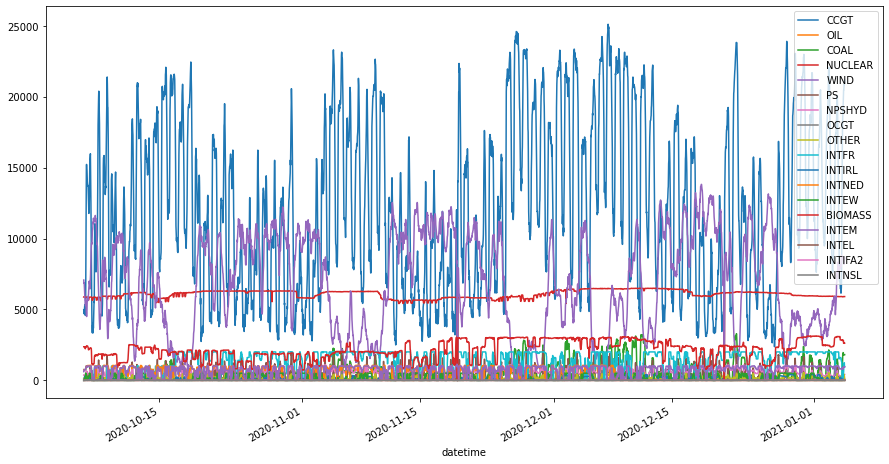

In [8]:
df.drop(
    ['HDF', 'date', 'half_hour_increment'], axis = 1
    ).set_index('datetime').plot(figsize=(15,8))


In [9]:
!pip install "cython==0.29.30"
!pip install 'pystan==3.5.0' convertdate plotly papermill requests dash
!pip install "prophet"


In [10]:
df_for_prophet = df[['datetime', fuel_type]].rename(columns = {'datetime':'ds', fuel_type:'y'})


In [11]:
X = df_for_prophet.copy()
y = df_for_prophet['y']
proportion_in_training = 0.8
split_index = int(proportion_in_training*len(y))
X_train, y_train = X.iloc[:split_index], y.iloc[:split_index]
X_test, y_test = X.iloc[split_index:], y.iloc[split_index:]


In [12]:
from prophet import Prophet
m = Prophet()
m.fit(X_train)


14:43:28 - cmdstanpy - INFO - Chain [1] start processing
14:43:29 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
future = m.make_future_dataframe(periods=int(len(y_test)/2), freq='H')
forecast = m.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail() #uncomment to inspect the DataFrame


<Figure size 432x288 with 0 Axes>

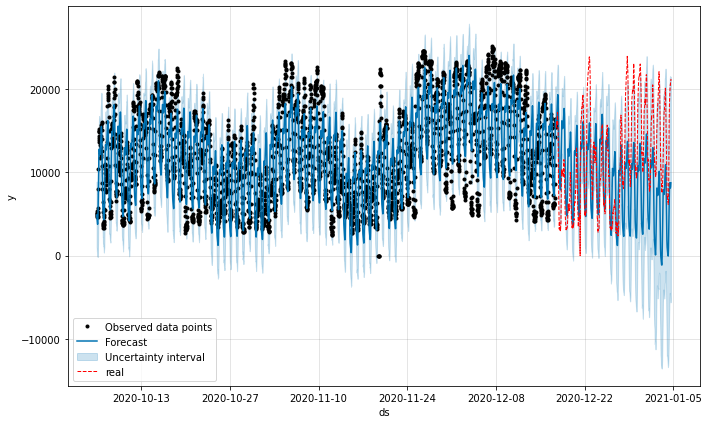

In [14]:
import matplotlib.pyplot as plt
plt.gcf()
fig = m.plot(forecast)
plt.plot(X_test['ds'].dt.to_pydatetime(), X_test['y'], 'r', linewidth = 1, linestyle = '--', label = 'real')
plt.legend()


In [15]:
import pickle
# m.stan_backend.logger = None    #uncomment if using Python 3.6 and fbprophet==0.6
with open("model.pkl", "wb") as f:
      pickle.dump(m, f)
